# Generating TensorRT Engines from TensorFlow

The UFF Toolkit allows you to convert TensorFlow models to UFF. The UFF parser can build TensorRT engines from these UFF models.

For this example, we train a LeNet5 model to classify handwritten digits and then build a TensorRT Engine for inference. Please make sure you have TensorFlow installed.

First, we need to import TensorFlow (Note: there is a know bug where TensorFlow needs to be imported before TensorRT. This will addressed in the future). 

In [1]:
import tensorflow as tf

We can then import TensorRT and the UFF parser.

In [2]:
import tensorrt as trt
from tensorrt.parsers import uffparser

We use PyCUDA to transfer data to/from the GPU and NumPy to store data.

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from random import randint # generate a random test case
from PIL import Image
from matplotlib.pyplot import imshow # To show test case
import time
import os

Finally, we need to import the UFF toolkit to convert the graph from a serialized frozen TensorFlow model to UFF.

In [4]:
import uff

## Training a Model in TensorFlow 

For more detailed information about training models in TensorFlow, see https://www.tensorflow.org/get_started/get_started.

First, we define hyper-parameters and helper functions for convenience. We will then define a network, our loss metrics, training/test steps, our input nodes, and a data loader.

In [5]:
STARTER_LEARNING_RATE = 1e-4
BATCH_SIZE = 10
NUM_CLASSES = 10
MAX_STEPS = 3000
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE ** 2
OUTPUT_NAMES = ["fc2/Relu"]

*Notice that we are padding our Conv2d layer. TensorRT expects symmetric padding for layers.*

In [6]:
def WeightsVariable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1, name='weights'))

def BiasVariable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape, name='biases'))

def Conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    filter_size = W.get_shape().as_list()
    pad_size = filter_size[0]//2
    pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
    x = tf.pad(x, pad_mat)
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def MaxPool2x2(x, k=2):
    # MaxPool2D wrapper
    pad_size = k//2
    pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')


In [7]:
def network(images):
    # Convolution 1
    with tf.name_scope('conv1'):
        weights = WeightsVariable([5,5,1,32])
        biases = BiasVariable([32])
        conv1 = tf.nn.relu(Conv2d(images, weights, biases))
        pool1 = MaxPool2x2(conv1)

    # Convolution 2
    with tf.name_scope('conv2'):
        weights = WeightsVariable([5,5,32,64])
        biases = BiasVariable([64])
        conv2 = tf.nn.relu(Conv2d(pool1, weights, biases))
        pool2 = MaxPool2x2(conv2)
        pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Fully Connected 1
    with tf.name_scope('fc1'):
        weights = WeightsVariable([7 * 7 * 64, 1024])
        biases = BiasVariable([1024])
        fc1 = tf.nn.relu(tf.matmul(pool2_flat, weights) + biases)

    # Fully Connected 2
    with tf.name_scope('fc2'):
        weights = WeightsVariable([1024, 10])
        biases = BiasVariable([10])
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases)

    return fc2


In [8]:
def loss_metrics(logits, labels):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, 
                                                                   logits=logits, 
                                                                   name='softmax')
    return tf.reduce_mean(cross_entropy, name='softmax_mean')

In [9]:
def training(loss):
    tf.summary.scalar('loss', loss)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE, 
                                               global_step, 
                                               100000, 
                                               0.75, 
                                               staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

In [10]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [11]:
def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set,
            summary):

    true_count = 0
    steps_per_epoch = data_set.num_examples // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    for step in range(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        log, correctness = sess.run([summary, eval_correct], feed_dict=feed_dict)
        true_count += correctness
    precision = float(true_count) / num_examples
    tf.summary.scalar('precision', tf.constant(precision))
    print('Num examples %d, Num Correct: %d Precision @ 1: %0.04f' % 
          (num_examples, true_count, precision))
    return log

In [12]:
def placeholder_inputs(batch_size):
    images_placeholder = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    labels_placeholder = tf.placeholder(tf.int32, shape=(None))
    return images_placeholder, labels_placeholder


In [13]:
def fill_feed_dict(data_set, images_pl, labels_pl):
    images_feed, labels_feed = data_set.next_batch(BATCH_SIZE)
    feed_dict = {
        images_pl: np.reshape(images_feed, (-1,28,28,1)),
        labels_pl: labels_feed,
    }
    return feed_dict


We define our training pipeline in a function that will return a frozen model with the training nodes removed.

In [14]:
def run_training(data_sets):
    with tf.Graph().as_default():
        images_placeholder, labels_placeholder = placeholder_inputs(BATCH_SIZE)
        logits = network(images_placeholder)
        loss = loss_metrics(logits, labels_placeholder)
        train_op = training(loss)
        eval_correct = evaluation(logits, labels_placeholder)
        summary = tf.summary.merge_all()
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        summary_writer = tf.summary.FileWriter("/tmp/tensorflow/mnist/log", 
                                               graph=tf.get_default_graph())
        test_writer = tf.summary.FileWriter("/tmp/tensorflow/mnist/log/validation",  
                                            graph=tf.get_default_graph())
        sess.run(init)
        for step in range(MAX_STEPS):
            start_time = time.time()
            feed_dict = fill_feed_dict(data_sets.train,
                                       images_placeholder,
                                       labels_placeholder)
            _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
            duration = time.time() - start_time
            if step % 100 == 0:
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()
            if (step + 1) % 1000 == 0 or (step + 1) == MAX_STEPS:
                checkpoint_file = os.path.join("/tmp/tensorflow/mnist/log", "model.ckpt")
                saver.save(sess, checkpoint_file, global_step=step)
                print('Validation Data Eval:')
                log = do_eval(sess,
                              eval_correct,
                              images_placeholder,
                              labels_placeholder,
                              data_sets.validation,
                              summary)
                test_writer.add_summary(log, step)
        # Return sess

        graphdef = tf.get_default_graph().as_graph_def()
        frozen_graph = tf.graph_util.convert_variables_to_constants(sess, 
                                                                    graphdef, 
                                                                    OUTPUT_NAMES)
        return tf.graph_util.remove_training_nodes(frozen_graph)


Now we load the TensorFlow MNIST data loader and run training. The model has summaries included, so you can visualize training in TensorBoard.

In [15]:
MNIST_DATASETS = tf.contrib.learn.datasets.load_dataset("mnist")
tf_model = run_training(MNIST_DATASETS)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Step 0: loss = 10.72 (0.123 sec)
Step 100: loss = 2.30 (0.019 sec)
Step 200: loss = 2.30 (0.018 sec)
Step 300: loss = 2.30 (0.018 sec)
Step 400: loss = 2.30 (0.017 sec)
Step 500: loss = 2.30 (0.017 sec)
Step 600: loss = 2.30 (0.018 sec)
Step 700: loss = 2.30 (0.017 sec)
Step 800: loss = 2.30 (0.017 sec)
Step 900: loss = 2.30 (0.017 sec)
Validation Data Eval:
Num examples 5000, Num Correct: 4912 Precision @ 1: 0.9824
Step 1000: loss = 2.30 (0.021 sec)
Step 1100: loss = 2.30 (0.018 sec)
Step 1200: loss = 2.30 (0.018 sec)
Step 1300: loss = 2.30 (0.018 sec)
Step 1400: loss = 2.30 (0.018 sec)
Step 1500: loss = 2.23 (0.018 sec)
Step 1600: loss = 2.31 (0.018 sec)
Step 1700: loss = 1.96 (0.017 sec)
Step 1800: loss = 2.31 (0.017 sec)
Step 1900: loss = 2.35 (0.017 sec)
Validation Data Eval:
Num examples 5

## Converting the TensorFlow Model to UFF
We can now convert the model into a serialized UFF model. To convert a model, we need to provide at least the model stream and the name(s) of the desired output node(s) to the `uff.from_tensorflow` function. The UFF Toolkit also includes a `uff.from_tensorflow_frozen_model` function which can create a UFF model from a TensorFlow frozen protobuf file. These functions have options for:


- `quiet` mode to suppress conversion logging


- `input_nodes` to allow you to define a set of input nodes in the graph (the defaults are Placeholder nodes)


- `text` will let you save a human readable version of UFF model alongside the binary UFF


- `list_nodes` will list the nodes in the graph 


- `output_filename` will write the model out to the filepath specified in addition to returning a serialized model


In [16]:
uff_model = uff.from_tensorflow(tf_model, ["fc2/Relu"])

Using output node fc2/Relu
Converting to UFF graph
No. nodes: 28


## Importing the UFF Model into TensorRT and Building an Engine 

We now have a UFF model stream with which we can build a TensorRT engine. We start by creating a logger for TensorRT.

In [17]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)

Next, we create a UFF parser and identify the desired input and output nodes.

In [18]:
parser = uffparser.create_uff_parser()
parser.register_input("Placeholder", (1,28,28), 0)
parser.register_output("fc2/Relu")

True

Now, we pass the logger, parser, uff model stream and some settings (max batch size and max workspace size) to a utility function that will build the engine for us.

In [19]:
engine = trt.utils.uff_to_trt_engine(G_LOGGER, uff_model, parser, 1, 1 << 20)

We can now get rid of the parser.

In [20]:
parser.destroy()

Now, we get a test case from the TensorFlow dataloader (converting it to FP32).

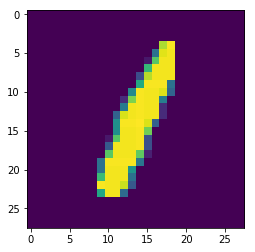

In [21]:
img, label = MNIST_DATASETS.test.next_batch(1)
img = img[0]
# Convert input data to Float32
img = img.astype(np.float32)
label = label[0]
%matplotlib inline
imshow(img.reshape(28,28))

Then, we create a runtime and an execution context for the engine.

In [22]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
context = engine.create_execution_context()

Next, we allocate memory on the GPU, as well as on the host to hold results after inference. The size of these allocations is the size of the input/expected output * the batch size.

In [23]:
output = np.empty(10, dtype = np.float32)

# Alocate device memory
d_input = cuda.mem_alloc(1 * img.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

The engine requires bindings (pointers to GPU memory). PyCUDA lets us do this by casting the results of memory allocations to ints.

In [24]:
bindings = [int(d_input), int(d_output)] 

We create a cuda stream to run inference.

In [25]:
stream = cuda.Stream()

Now, we transfer the data to the GPU, run inference, then transfer the results to the host.

In [26]:
# Transfer input data to device
cuda.memcpy_htod_async(d_input, img, stream)
# Execute model 
context.enqueue(1, bindings, stream.handle, None)
# Transfer predictions back
cuda.memcpy_dtoh_async(output, d_output, stream)
# Syncronize threads
stream.synchronize()

We can use `np.argmax` to get a prediction.

In [27]:
print("Test Case: " + str(label))
print ("Prediction: " + str(np.argmax(output)))

Test Case: 1
Prediction: 0


We can also save our engine to a file to use later.

In [28]:
trt.utils.write_engine_to_file("./tf_mnist.engine", engine.serialize()) 

True

You can load this engine later by using `tensorrt.utils.load_engine`.

In [29]:
new_engine = trt.utils.load_engine(G_LOGGER, "./tf_mnist.engine") 

Finally, we clean up our context, engine and runtime.

In [30]:
context.destroy()
engine.destroy()
new_engine.destroy()
runtime.destroy()